In [1]:
#
# Emre Alca
# University of Pennsylvania
# Created on Sat Nov 22 2025
#

In [2]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
import tqdm

from IPython.display import HTML

%matplotlib widget

from src import spindle_state as ss
import pickle
import os


Need to implement:
basic functionality for short timescales:
- [x] spindle state
- [x] pulling forces of a given spindle state
- [x] pushing forces of a given spindle state
- [x] equations of motion
- [x] time evolution

Turnover regimes
- [ ] Markovian catastrophe and nucleation 
- [ ] gradient descent
    - [x] cost function
    - [x] sampling spatial nucleation distribution
    - [x] sampling spatial catastrophe distribution
    - [x] sampling length nucleation distribution
    - [x] sampling length catastrophe distribution
    - [ ] spindle update
    - [ ] stochastic gradient descent loop



In [3]:
test_spindle_lattice = np.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1],
    [0, 0, -1],
])

expected_mt_vecs = np.array([
       [ 0.5,  0. ,  0. ],
       [-1.5,  0. ,  0. ],
       [-0.5,  1. ,  0. ],
       [-0.5, -1. ,  0. ],
       [-0.5,  0. ,  1. ],
       [-0.5,  0. , -1. ]])

test_spindle_state = np.array([1, 1, 3, 3, 1, 1])

test_spindle = ss.Spindle(np.array([0, 0, 0]), test_spindle_state, test_spindle_lattice, timestep_size=0.01)

In [4]:
# empty_pushing = test_spindle.lattice_sites[(test_spindle.spindle_state == 1)]
# filled_pushing = test_spindle.lattice_sites[(test_spindle.spindle_state == 2)]

# pushing_sites = np.concatenate((empty_pushing, filled_pushing))

In [5]:
# file_path = '/Users/emrealca/Documents/Penn/flatiron-microtubules/simulations/data/octahedron/[1 1 3 3 1 1]_2026-01-16_14-04-53.pkl'
# file_path = '/Users/emrealca/Documents/Penn/flatiron-microtubules/simulations/data/octahedron/[1 1 1 1 1 1]_2026-01-16_14-08-11.pkl'
# file_path = '/Users/emrealca/Documents/Penn/flatiron-microtubules/simulations/data/octahedron/[3 3 3 3 3 3]_2026-01-16_14-09-00.pkl'
# file_path = '/Users/emrealca/Documents/Penn/flatiron-microtubules/simulations/data/octahedron/[3 3 1 3 3 3]_2026-01-16_14-28-11.pkl'
file_path = '/Users/emrealca/Documents/Penn/flatiron-microtubules/simulations/data/1d-validation/[1 3]_2026-01-22_10-11-06.pkl'

with open(file_path, "rb") as f:
    data = pickle.load(f)

trajectory = data['trajectory']
spindle = data['spindle']

ts = list(trajectory.keys())

xs = []
ys = []
zs = []
spindle_states = []

for key in list(trajectory.keys()):

    xs.append(trajectory[key]['mtoc_pos'][0])
    ys.append(trajectory[key]['mtoc_pos'][1])
    zs.append(trajectory[key]['mtoc_pos'][2])

    spindle_states.append(trajectory[key]['spindle_state'].astype(int))

spindle_states = np.array(spindle_states)

reformatted_trajectory = np.column_stack([ts, xs, ys, zs])

traj_to_plot = reformatted_trajectory[::10]

In [6]:
i = 40000
rolling_probabilities_list = []
for i in range(len(ts)-1000):
    i += 1000

    spindle_occupancy_counts = []
    for state in range(len(spindle['spindle_state'])):
        unique,counts = np.unique(spindle_states[i-1000:i, state], return_counts=True)
        spindle_occupancy_counts.append(counts[-1])
        rolling_probabilities = np.array(spindle_occupancy_counts)/1000

    rolling_probabilities_list.append(rolling_probabilities)

np.array(rolling_probabilities_list)

array([[1.000, 1.000],
       [1.000, 1.000],
       [1.000, 1.000],
       ...,
       [1.000, 1.000],
       [1.000, 1.000],
       [1.000, 1.000]], shape=(49700, 2))

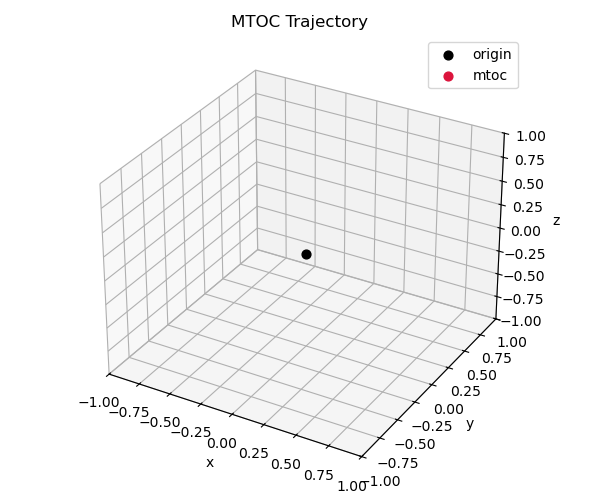

In [7]:
# ---- Extract columns ----
t = traj_to_plot[:, 0]
x = traj_to_plot[:, 1]
y = traj_to_plot[:, 2]
z = traj_to_plot[:, 3]

# ---- Set up figure ----
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# Precompute limits so they don't rescale during animation
pad = 0.05
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
zmin, zmax = z.min(), z.max()
xr = xmax - xmin; yr = ymax - ymin; zr = zmax - zmin
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('MTOC Trajectory')

# static origin
target = ax.scatter([0], [0], [0], s=40, color='black', label='origin')

# Line for the trail and a scatter for the head
(line,) = ax.plot([], [], [], lw=2, color='tab:blue')
head = ax.scatter([], [], [], s=40, color='crimson', label='mtoc')

# text in corner
spindle_state_text = ax.text2D(0.02, 0.95, '', transform=ax.transAxes)
spindle_state_rolling_probabilities_text = ax.text2D(0.02, 0.90, '', transform=ax.transAxes)
time_text = ax.text2D(0.02, 0.80, '', transform=ax.transAxes)
cost_text = ax.text2D(0.02, 0.85, '', transform=ax.transAxes)

ax.legend()

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    head._offsets3d = ([], [], [])
    time_text.set_text('')
    cost_text.set_text('')
    spindle_state_text.set_text('')
    spindle_state_rolling_probabilities_text.set_text('')
    return line, head, time_text

def update(i):
    # Draw up to frame i
    line.set_data(x[:i+1], y[:i+1])
    line.set_3d_properties(z[:i+1])
    head._offsets3d = (np.array([x[i]]), np.array([y[i]]), np.array([z[i]]))

    time_text.set_text(f't = {t[i]:.2f}')

    cost = np.round(trajectory[t[i]]['cost'], 3)
    cost_text.set_text(f'cost = {cost}')
    spindle_state = trajectory[t[i]]['spindle_state'].astype(int)
    spindle_state_text.set_text(f'spindle state: {spindle_state}')
    return line, head, time_text

# Interval controls speed (ms between frames). 
# If your t is in seconds, you can compute an interval that matches real time:
#   intervals = np.diff(t); avg = np.mean(intervals); interval_ms = avg*1000
# For simplicity, use a fixed interval:
ani = FuncAnimation(fig, update, frames=len(t), init_func=init,
                    interval=0.001, blit=False, repeat=True)

plt.tight_layout()
plt.show()